In [2]:
import qutip as qt
import numpy as np
import seaborn as sns
from collections import deque
import cmath as cm

In [3]:
def find_shortest_path(connectivity_graph: np.ndarray, start_node, end_node):
    """
    Given a connectivity graph, find the shortest path between two nodes via breadth-first search.
    """
    m, n = connectivity_graph.shape
    if start_node < 0 or start_node >= m or end_node < 0 or end_node >= n:
        raise ValueError("Start or end node is out of bounds.")

    visited_nodes = set()
    queue = deque([(start_node, [start_node])]) # (node, path)

    while queue:
        current_node, path = queue.popleft()

        if current_node == end_node:
            return path 
        
        if current_node not in visited_nodes:
            visited_nodes.add(current_node)
            neighbors = [i for i in range(n) if connectivity_graph[current_node, i] == 1]

            for neighbor in neighbors:
                if neighbor not in visited_nodes:
                    queue.append((neighbor, path + [neighbor]))
    return -1, [] # no path found

In [4]:
matrix = [
    [0, 1, 0, 0, 0],
    [1, 0, 1, 1, 0],
    [0, 1, 0, 0, 1],
    [0, 1, 0, 0, 1],
    [0, 0, 1, 1, 0]
]
print(find_shortest_path(np.array(matrix), 0, 3))

[0, 1, 3]


In [5]:
def decompose_givens_matrix(Q_i: np.ndarray, connectivity_graph: np.ndarray, path: np.ndarray, levels: tuple):
    """
    Given a Givens rotation matrix Q_i, check if said decomposition is possible given the connectivity graph, and 
    if not return the appropriate decomposition via using additional swap gates. 
    """
    m, _ = connectivity_graph.shape
    c, s = Q_i[levels[0], levels[0]], Q_i[levels[1], levels[0]]
    G_i = np.eye(m).astype(complex)
    allowed_decompositions = []
    
    if path == -1:
        raise ValueError("No path found between start and end nodes.")
    else: 
        # write a swap matrix (pauli-x) for each pair of nodes except for the last 2 nodes in the path
        for i in range(len(path) - 2):
            swap_matrix = np.eye(m)
            swap_matrix[path[i], path[i]] = 0
            swap_matrix[path[i+1], path[i+1]] = 0
            swap_matrix[path[i], path[i+1]] = 1
            swap_matrix[path[i+1], path[i]] = 1
            allowed_decompositions.append(swap_matrix)

        '''
        slightly alter the Q_i so as to be a rotation between the second last and last nodes in the path 
        while keeping the same form as that of original givens rotation
        '''
        x, y = len(path) - 2, len(path) - 1
        G_i[path[x], path[x]], G_i[path[y], path[y]] = c, c
        G_i[path[x], path[y]], G_i[path[y], path[x]] = s, -s
        allowed_decompositions.append(G_i)

        # return the intermediate swap states back to their original form
        for i in range(len(path) - 2, 0, -1):
            swap_matrix = np.eye(m)
            swap_matrix[path[i], path[i]] = 0
            swap_matrix[path[i-1], path[i-1]] = 0
            swap_matrix[path[i], path[i-1]] = 1
            swap_matrix[path[i-1], path[i]] = 1
            allowed_decompositions.append(swap_matrix)
        
        return allowed_decompositions

In [6]:
# sample givens rotation matrix 
G_12 = np.array([
    [1, 0, 0, 0, 0],
    [0, 0.8, 0.6, 0, 0],
    [0, -0.6, 0.8, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1]
])
# first connectivity graph, we want 1 -> 3 -> 2 
matrix_1 = np.array([
    [0, 1, 0, 0, 0],
    [1, 0, 0, 1, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 1],
    [0, 0, 0, 1, 0]
])

# second connectivity graph, we want 1 -> 3 -> 4 -> 2
matrix2 = np.array([
    [0, 1, 0, 0, 0],
    [1, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0]
])

path_1 = find_shortest_path(matrix_1, 1, 2)
path_2 = find_shortest_path(matrix2, 1, 2)
print(path_1)
print(path_2)

[1, 3, 2]
[1, 3, 4, 2]


In [7]:
# decompose the givens matrix into a series of swap gates for the first connectivity graph
rotations_1 = decompose_givens_matrix(G_12, matrix_1, path_1, (1, 2))
recovered_G12_path1 = np.eye(5)
for rotation in rotations_1:
    recovered_G12_path1 = rotation @ recovered_G12_path1
print(recovered_G12_path1.T)

[[ 1. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.8+0.j  0.6+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.6+0.j  0.8+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  1. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. +0.j]]


In [8]:
# decompose the givens matrix into a series of swap gates for the second connectivity graph
rotations_2 = decompose_givens_matrix(G_12, matrix2, path_2, (1, 2))
recovered_G12_path2 = np.eye(5)
for rotation in rotations_2:
    recovered_G12_path2 = rotation @ recovered_G12_path2
print(recovered_G12_path2.T)

[[ 1. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.8+0.j  0.6+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.6+0.j  0.8+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  1. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. +0.j]]


In [9]:
# check if the decomposed givens matrix is the same as the original givens matrix
print(np.allclose(G_12, recovered_G12_path1.T))
print(np.allclose(G_12, recovered_G12_path2.T))

True
True


In [10]:
def decompose_phase_matrix(R: np.ndarray):
    """
    Given a phase matrix R, decompose it into a product of phase gates (this assumption only holds for unitary starting matrices)
    """
    phase_gates = []
    for i in range(len(R)):
        phase_gate = np.eye(len(R)).astype(complex)
        phase_gate[i, i] = R[i, i]
        phase_gates.append(phase_gate)
    return phase_gates

In [11]:
# testing the decomposition of a diagonal matrix into a product of phase gates
phase_matrix = np.diag([1, 1, 1, cm.exp(1j * np.pi / 4)])
recovered_matrix = np.eye(4) 
for gate in decompose_phase_matrix(phase_matrix):
    recovered_matrix = gate @ recovered_matrix
print(np.allclose(phase_matrix, recovered_matrix))

True


In [12]:
def qr_decomposition(M, connectivity_graph: np.ndarray):
    """
    Given a square matrix M, return the QR decomposition via Givens rotations.
    """
    m, n = M.shape
    # make a complex copy of M
    Q = np.eye(m).astype(complex)
    R = M.copy().astype(complex)
    givens_matrices = []

    # iterate over lower triangular entries
    (rows, columns) = np.tril_indices(m, -1, n)
    for i, j in zip(rows, columns):
        # obtaining the givens parameters
        c, s = 1, 0
        if M[i, j] != 0:
            r = cm.sqrt(M[i, j]**2 + M[j, j]**2)
            c, s = M[j, j]/r, -M[i, j]/r

        # generating the actual givens rotation matrix
        G = np.eye(m).astype(complex)
        G[[i, j], [i, j]] = c
        G[i, j] = s
        G[j, i] = -s

        path = find_shortest_path(connectivity_graph, i, j)
        if not np.allclose(G, np.eye(m)):
            if len(path) == 1:
                givens_matrices.append(G)
            else:
                givens_matrices.extend(decompose_givens_matrix(G, connectivity_graph, path, (i, j)))

        # updating Q and R
        Q = np.dot(Q, G.T)
        R = np.dot(G, R)

    return givens_matrices, Q, R

In [13]:
U_4 = qt.Qobj(qt.rand_unitary(4))
givens_matrices, Q, R = qr_decomposition(U_4.full(), np.array(matrix))
print(np.allclose(np.dot(Q, R), U_4.full()))

True


In [14]:
sns.set_theme(style="darkgrid")

In [15]:
# make a plot of the length of the decomposition vs dimension of the via seaborn 
# this is assuming that the connectivity graph is a complete graph
def plot_results_wrt_dimension(connectivity_graph: np.ndarray, dimensions: np.ndarray, graph_type: str):
    lengths = []
    for dim in dimensions:
        U = qt.Qobj(qt.rand_unitary(dim))
        givens_matrices, _, R = qr_decomposition(U.full(), connectivity_graph)
        phase_gates = decompose_phase_matrix(R)
        lengths.append(len(givens_matrices) + len(phase_gates))
    plot = sns.scatterplot(x=dimensions, y=lengths)
    plot.set(xlabel="Dimension", ylabel="Length of decomposition")

In [16]:
def plot_results_wrt_connectivity_graph(connectivity_graphs: list, dimension: int):
    lengths = []
    for graph in connectivity_graphs:
        U = qt.Qobj(qt.rand_unitary(dimension))
        givens_matrices, _, R = qr_decomposition(U.full(), graph)
        phase_gates = decompose_phase_matrix(R)
        lengths.append(len(givens_matrices) + len(phase_gates))
    sns.set_theme(style="darkgrid", font="montserrat", font_scale=0.9)
    plot = sns.scatterplot(x=range(len(connectivity_graphs)), y=lengths)
    plot.set(xlabel="Connectivity graph", ylabel="Length of decomposition")

In [17]:
complete_graph = np.ones((5, 5)) - np.eye(5)
potential_trapped_ion_graph = np.array([
    [0, 1, 1, 1, 1], 
    [1, 0, 1, 0, 1], 
    [1, 1, 0, 0, 0], 
    [1, 0, 0, 0, 1], 
    [1, 1, 0, 1, 0]
])
current_trapped_ion_graph = np.array([
    [0, 1, 1, 1, 1],
    [1, 0, 0, 0, 0], 
    [1, 0, 0, 0, 0], 
    [1, 0, 0, 0, 0], 
    [1, 0, 0, 0, 0]
])
superconducting_graph = np.array([
    [0, 1, 0, 0, 1], 
    [1, 0, 0, 0, 0], 
    [0, 0, 0, 1, 0], 
    [0, 0, 1, 0, 1],
    [1, 0, 0, 1, 0]
])
connectivity_graphs = [complete_graph, potential_trapped_ion_graph, current_trapped_ion_graph, superconducting_graph]
# plot_results_wrt_connectivity_graph(connectivity_graphs, 5)

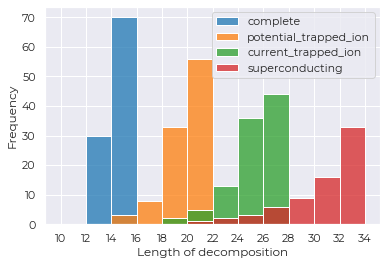

In [29]:
num_trials = 100
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
graph_type = ["complete", "potential_trapped_ion", "current_trapped_ion", "superconducting"]
unitaries = [np.array(qt.Qobj(qt.rand_unitary(5))) for _ in range(num_trials)]
# unitaries = [np.random.randint(5, size=(5, 5)) for _ in range(num_trials)]
epsilon = 1e-1
# snapping values that are close to 0 to be identically 0
for random_unitary in unitaries:
    for i in range(len(random_unitary)):
        for j in range(len(random_unitary)):
            if cm.isclose(random_unitary[i, j], 0, abs_tol=epsilon):
                random_unitary[i, j] = 0

for i, graph in enumerate(connectivity_graphs):
    lengths = []
    for random_unitary in unitaries:
        givens_matrices, _, R = qr_decomposition(random_unitary.astype(complex), graph)
        phase_gates = decompose_phase_matrix(R)
        lengths.append(len(givens_matrices) + len(phase_gates))
    sns.set_theme(style="darkgrid", font="montserrat")
    plot = sns.histplot(lengths, color=colors[i], label=graph_type[i], bins = range(10, 35, 2))
    # make x-axis finer 
    plot.set(xticks=range(10, 35, 2))
    plot.set(xlabel="Length of decomposition", ylabel="Frequency")
    plot.legend()

In [72]:
random_orthornormal = np.random.rand(5, 5)
random_ortho1 = np.random.rand(5, 5)
random_orthornormal[1, 0] = 0
random_orthornormal[2, 0] = 0
print(np.allclose(random_ortho1, random_orthornormal))
print(random_orthornormal)

False
[[0.63460645 0.37319003 0.07865416 0.18175589 0.16030006]
 [0.         0.55207517 0.46849047 0.98671149 0.14682796]
 [0.         0.9869826  0.71372947 0.12207208 0.16351305]
 [0.12497293 0.63673612 0.81513145 0.48155083 0.60152702]
 [0.13812336 0.29310208 0.90598936 0.12487136 0.67456774]]


In [182]:
ortho, _, _ = qr_decomposition(random_orthornormal, connectivity_graphs[2])
ortho1, _, _ = qr_decomposition(random_ortho1, connectivity_graphs[2])
print(len(ortho))
print(len(ortho1))

20
22
